## Nitrate Leachate and Deep Drainage Analysis (randomized block design)

**Note:** The data used here is an example and not necessarily based on real-world data. This is more of a guide for our internal NASA ARC CREST group, along with partners, students, and collaborators. The example here represents a study that would be conducted in a  large-scale commercial agricultural setting.

**Purpose of Notebook:** Document a general workflow that can be used as a starting place when analyzing deep drainage/leachate from field studies using G3 lysimeters to collect drainage/leachate data, flow meters to collect total applied water data, and CropManage to collect total applied fertilizer. 

[Link to G3 Drain Gauge Manual](http://library.metergroup.com/Manuals/13677_G3%20Drain%20Gauge_Web.pdf)



**Data Needed for Analysis:** The following 3 datasets in the Tidy Format are required (see example data on Github)

[Link to Repository on Jason Dexter's GitHub that includes example datasets](https://github.com/j-dexter/lysimeter-G3-nitrate-leachate-analyis)

1. Fertilizer Application: **tidy-fertilizer-data**
2. Drainage and Leachate: **tidy-lysimeter-data**
3. Irrigation Application: **tidy-irrigation-data**

**Note:** It is very important that you setup your tables the same way as the tidy-data examples (long-table format, not wide-table).

[Link to Tidy Data explanation (Hadley Wickham)](http://vita.had.co.nz/papers/tidy-data.html)

# Sections included in this Jupyter Notebook
1. Creating variables specific to study
2. Importing libraries and setting parameters for plotting/visualizations
3. Importing and preparing datasets
4. Exploratory Data Analysis (raw leachate/drainage data)
5. Perform calculations and scaling on lysimeter data to calculate final metrics.
6. Visualize and plot deep drainage and leachate over time.
7. Incorporate irrigation data to visualize and compare Total Applied Water vs. Total Deep Drainage.
8. Incorporate fertilizer data to visualize and compare Total Applied Fertilizer vs. Total Leachate.

---

## Section 01: Creating variables specific to study (set specific to your needs)

In [1]:
# Important variables used later in analysis (update with specific values pertaining to your study)

# Treatment names as they are in the tidy-datasets (for treatment comparisons)
treatment_one = 'ET 130'
treatment_two = 'CropManage'

# Area of the divergence control tube (aoi_cm2) tube from the G3 lysimeter (i.e., Area of Influence)
aoi_cm2 = 506.7  # CHANGE IF YOU HAVE DETERMINED AN ALTERNATIVE VALUE FOR YOUR AOI

# Bed dimensions for crop studied (used for scaling results by assuming zero leaching in furrows)
'''If you want to try the analysis without scaling, then replace both values below with the number 1'''
width_of_bed = 60 # inches
width_of_bed_plus_furrows = 80 #inches

# Path to directory containing tidy-datasets (your jupyter notebook should be in the same place)
path = r'C:\Users\jdext\Desktop\lysimeter-G3-nitrate-leachate-analyis'

# Output directory that will be used to create
output = 'final_output'

## Section 02: Importing libraries and setting parameters for plotting/visualizations

In [2]:
# Importing the libraries
import os, shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Magic command so that plots show in Notebook
%matplotlib inline

In [3]:
# Setting style for all figures that will be made throughout notebook
sns.set_context("paper")
sns.set(font='serif')
sns.set_style("white", {"font.family": "serif","font.serif": ["Times", "Palatino", "serif"]})

# set color scheme for plotting treatments summaries and assign them to lists
colors_3 = ['lightcoral', 'seagreen', 'steelblue']   # with grower
colors_2 = ['seagreen', 'steelblue']    # without grower

# set order that treatments will be displayed in figures/plots and assign to lists
order_3 = ['Grower','CropManage','ET 130']
order_2 = ['CropManage','ET 130']

## Section 03: Importing and preparing datasets

In [4]:
# Change working directory using 'path' and print current directory for varification
os.chdir(path); print(os.getcwd())

# Create output directory
if not os.path.exists(output):  # this creates directory if it does not exist
    os.makedirs(output)
else:                                   # this removes and recreates directory if it exists
    shutil.rmtree(output)          
    os.makedirs(output)

# Importing the datasets
fertilizer = pd.read_excel('_tidy-fertilizer-data.xlsx', header=0)
irrigation = pd.read_excel('_tidy-irrigation-data.xlsx', header=0)
lysimeter = pd.read_excel('_tidy-lysimeter-data.xlsx', header=0)

C:\Users\jdext\Desktop\lysimeter-G3-nitrate-leachate-analyis


#### Prepare tidy-ferlizer-data for analysis (applied Nitrogen data)

In [5]:
# Subset columns needed for analysis
applied_N = fertilizer[['date','treatment','application_type','fertilizer','N_lbs_per_acre']].copy()

# Set columns to appropriate data types
applied_N.treatment = fertilizer.treatment.astype('category')

# View prepared ferlizer data
applied_N.sample(5) # choose 5 random records and display as pandas dataframe

,date,treatment,application_type,fertilizer,N_lbs_per_acre
11,2017-05-31,ET 130,2nd Drip Fertigation,20-0-0,45.1
9,2017-05-09,ET 130,1st Sidedress,20-0-0,73.5
10,2017-05-24,ET 130,1st Drip Fertigation,20-0-0,60.1
7,2017-05-31,CropManage,2nd Drip Fertigation,20-0-0,30.0
6,2017-05-24,CropManage,1st Drip Fertigation,20-0-0,39.9


#### Prepare tidy-lysimeter-data (deep drainage and leachate data)

In [6]:
# Subset columns needed for analysis
leachate_raw = lysimeter.loc[:, ['event', 'date', 'DAP', 'treatment', 'replicate', 'drainage_ml', 'N_mg_per_L'] ].copy()

# rename drainage_ml to drainage_cm3 so that later conversions and calculations makes more sense
leachate_raw.rename(columns={'drainage_ml': 'drainage_cm3'}, inplace=True)  # 1 ml = 1 cm^3

# Set columns to appropriate data types
leachate_raw.replicate = leachate_raw.replicate.astype('category')
leachate_raw.treatment = leachate_raw.treatment.astype('category')

# View prepared lysimeter data
leachate_raw.sample(5) # choose 5 random records and display as pandas dataframe

,event,date,DAP,treatment,replicate,drainage_cm3,N_mg_per_L
66,9,2017-06-16,65,ET 130,Rep C,210,164.714286
38,5,2017-05-31,49,CropManage,Rep C,0,0.000000
23,3,2017-05-18,36,CropManage,Rep D,0,0.000000
33,5,2017-05-31,49,ET 130,Rep B,1100,157.036364
42,6,2017-06-05,54,ET 130,Rep C,185,142.675676


#### Prepare tidy-irrigation-data for analysis (applied water data)
**Note:** The raw irrigation data collected by flow meters was converted from gallons to inches using the acreage of each treatment.

In [7]:
# Subset columns needed for analysis
applied_h2o = irrigation.loc[:, ['date', 'DAP', 'treatment', 'irrigation_type', 'irrigation_in', 'irrigation_mm']].copy()

# Set columns to appropriate data types
applied_h2o.treatment = applied_h2o.treatment.astype('category')
applied_h2o.irrigation_type = applied_h2o.irrigation_type.astype('category')

# View prepared irrigation data
applied_h2o.sample(5) # choose 5 random records and display as pandas dataframe

,date,DAP,treatment,irrigation_type,irrigation_in,irrigation_mm
31,2017-06-16,65,Grower,drip,0.44,11.176
26,2017-06-13,62,CropManage,drip,0.90,22.860
18,2017-05-31,49,ET 130,drip,1.12,28.448
19,2017-05-31,49,Grower,drip,0.44,11.176
11,2017-05-20,38,CropManage,drip,0.50,12.700


# Section 04: Exploratory Data Analysis (raw leachate/drainage data)

### Output directory is specifically for output figures and the output drainage/leachate table

In [8]:
# Change working directory using 'ouput' and print current directory for varification
os.chdir(output); print(os.getcwd())

C:\Users\jdext\Desktop\lysimeter-G3-nitrate-leachate-analyis\final_output


In [9]:
# setup function for plotting raw lysimeter data
def explore_raw_lysimeter_data(raw_data, treatment_one, treatment_two): 
    fig, ax=plt.subplots(2,1,figsize=(10,8)) # initiate figure and axis objects
    sns.set(style="ticks", rc={"lines.linewidth": 1}) # controls the width of the plotted lines
    # plot drainage
    ax = sns.pointplot(x="DAP", y="drainage_cm3", hue="treatment", hue_order=[treatment_one, treatment_two],
                       data=raw_data, palette=['black','grey'],errwidth=1, markers=["o", "^"],
                       capsize=0.25, linestyles=["-", "--"], linewidth=5, ax=ax[0]) 
    ax.set_xlabel(xlabel='', fontsize=20,labelpad=15);
    ax.set_ylabel('Pumped drainage (ml)', fontsize=14, labelpad=14); # ax.set_ylim(-20,300)
    ax.tick_params(labelsize=15); 
    # plot nitrate concentration
    ax1 = sns.pointplot(x="DAP", y="N_mg_per_L", hue="treatment", hue_order=[treatment_one, treatment_two],
                        data=raw_data, palette=['black','grey'],
                       errwidth=1, markers=["o", "^"], capsize=0.25, linestyles=["-", "--"], linewidth=5)
    ax1.set_xlabel(xlabel='Days After Transplant (DAT)', fontsize=16,labelpad=15);
    ax1.set_ylabel('Nitrate concentration (mg/L)', fontsize=14, labelpad=14); # ax1.set_ylim(-20,300) 
    ax1.tick_params(labelsize=15); 
    sns.despine() # remove upper and righhand spines
    return fig, ax

#### Plot the unscaled raw lysimeter data that was pumped/collected on site and the raw nitrate concentrations from the laboratory analysis.

**Note:** This is the mean of the replicates associated with each treatment

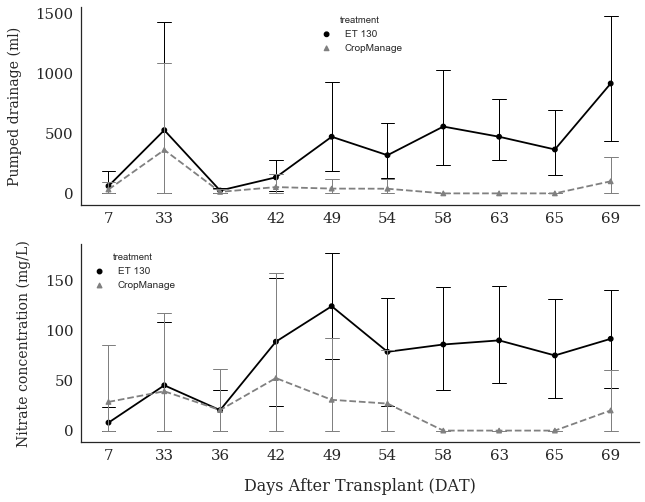

In [10]:
# Use function and view plot of raw unscaled data
explore_raw_lysimeter_data(leachate_raw, treatment_one, treatment_two)
plt.savefig('explore_raw_lysimeter_data')

#### Scatter plot of concentrations followed by drainage for each treatment to see variation with treatment replicates

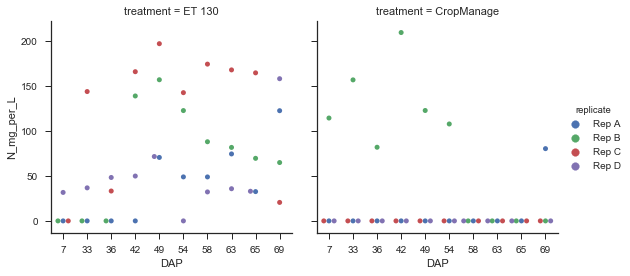

In [11]:
# Explore nitrate concentration (mg/L) and the variability between treatments and replicates
sns.factorplot(x="DAP", y="N_mg_per_L", hue="replicate",
    col="treatment", data=lysimeter, kind="swarm")
plt.savefig('explore_raw_nitrate_data')

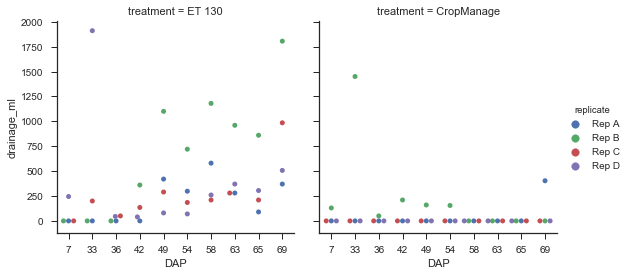

In [12]:
# Explore drainage volumes (ml) and the variability between treatments and replicates
sns.factorplot(x="DAP", y="drainage_ml", hue="replicate",
    col="treatment", data=lysimeter, kind="swarm")
plt.savefig('explore_raw_drainage_data')

## Section 05: Perform calculations and scaling on lysimeter data to calculate final metrics.

**Note:** This is the primary section of the leachate analysis. Here we are applying specific calculations and conversions that take the raw drainage data and the raw nitrate concentration data and transform them into the final metrics. The final metrics will be in the appropriate units that allow for easy comparisons with other summary statistics (e.g., applied water/acre and applied fertilizer/acre)

**The general workflow for the leachate analysis is as follows:**

1. Setup conversion factors.
2. Determine and create necessary area of influence (AOI) and scaling factor.
3. Use pumped volumes and nitrate concentrations to calculate each component necessary for the final metrics.
    - Calculate drainage in inches (from volume). 
    - Convert milliliters (same as cm^3 b/c 1 ml = 1 cm^3) to liters.
    - Calculate milligrams of N (N_mg) by multiplying drainage (L) times concentration (mg/L).
    - Calculate pounds of N (N_lbs) by multiplying concentration (N_mg) times the milligrams to pounds conversion factor.
    - Calculate pounds of N per square centimeters.
    - Calculate pounds of N per acre.

**Note:** Each of these calculations and/or conversions is added as a new column to the leachate data frame (calculations happen to each instance (record) in the dataframe). The output dataframe then has everything to easily summarize drainage or leachate for the study (e.g., by treatment and by replicate)

#### 1) Setup conversion factors

In [13]:
# Conversions needed for analysis
# conversion factor for milligrams to pounds (lbs in a mg)
mg_to_lbs = 0.0000022046   #   lb = mg * 0.0000022046

# conversion factor for total square cinemiters in an Acre
cm2_in_acre = 40468564.224

# Conversion factor for going from inches to centimeters
inch_to_cm = 2.54 # conversion factor: centimeters per inch

# Conversion factor for going from centimeters to inches
cm_to_inches = 0.393701 # conversion factor: inches per centimeter

#### 2) Determine and create necessary area of influence (AOI) and scaling factor (assumes no leaching in furrows).

**Note:** These are in centimeters because they will be used to do calculations on drainage in the leachate dataframe

In [14]:
# Function to create scaling factor that assumes no leaching in furrows
def create_scaling_factor(width_of_bed=1, width_of_bed_plus_furrows=1):
    '''The output of this function will be in centimeters'''
    '''This is important for later conversions'''
    # convert width of just the bed from inches to centimeters
    width_of_bed_cm = width_of_bed * inch_to_cm # centimeters
    # convert width of bed (with furrows) from inches to centimeters
    width_of_bed_plus_furrows_cm = width_of_bed_plus_furrows * inch_to_cm # centimeters
    # calculate scaling factor that assumes there was no drainage in furrows
    scaling_factor_cm = width_of_bed_cm / width_of_bed_plus_furrows_cm    
    return scaling_factor_cm

furrow_scalar = create_scaling_factor(width_of_bed, width_of_bed_plus_furrows)

# Check to be sure aoi_cm2 and furrow_scalar are what you expect
print("The Area of Influence being used is: ", aoi_cm2, " cm")
print("The Scaling factor used that assumes the furrows had no drainage is: ", furrow_scalar)

The Area of Influence being used is:  506.7  cm
The Scaling factor used that assumes the furrows had no drainage is:  0.7500000000000001


**Important:** Double check scalar and area of influence printout above to be sure it's what you expected.

## Now, we are scaling the data and converted everything to appropriate units

#### 3) Use pumped volumes and nitrate concentrations to calculate each component necessary for the final metrics.

In [15]:
# Calculate drainage in inches (in) for each record and add resulting column to dataframe
leachate_raw.loc[:,'drainage_in'] = (leachate_raw.loc[:, 'drainage_cm3'] / aoi_cm2) * furrow_scalar * cm_to_inches

# Calculate drainage in liters (L) for each record and add resulting column to dataframe
leachate_raw.loc[:,'drainage_L'] = leachate_raw.loc[:,'drainage_cm3'] / 1000

# Calculate nitrate in miligrams (mg) for each record and add resulting column to dataframe
leachate_raw.loc[:,'N_mg'] = leachate_raw.loc[:,'N_mg_per_L'] * leachate_raw.loc[:,'drainage_L'] 

# Calculate nitrate in pounds (lb) for each record and add resulting column to dataframe
leachate_raw.loc[:,'N_lbs'] = leachate_raw.loc[:,'N_mg'] * mg_to_lbs

# Calculate lbs of N per sampling area (cm^2) for each record and add resulting column to dataframe
leachate_raw.loc[:,'N_lbs_per_cm2'] = (leachate_raw.loc[:,'N_lbs'] / aoi_cm2 * furrow_scalar)

# Convert lbs of N per cm^2 to lbs of N per Acre for each record and add resulting column to dataframe
leachate_raw.loc[:,'N_lbs_per_acre'] = leachate_raw.loc[:,'N_lbs_per_cm2'] * cm2_in_acre
    
# Save raw leachate data that has now been scaled into a new variable called: leachate_scaled
leachate_scaled = leachate_raw.copy()
    
# view 5 randomly selected records from your table
leachate_scaled.sample(5).round(2)

,event,date,DAP,treatment,replicate,drainage_cm3,N_mg_per_L,drainage_in,drainage_L,N_mg,N_lbs,N_lbs_per_cm2,N_lbs_per_acre
70,9,2017-06-16,65,CropManage,Rep C,0,0.00,0.00,0.00,0.00,0.0,0.0,0.00
67,9,2017-06-16,65,ET 130,Rep D,305,32.98,0.18,0.30,10.06,0.0,0.0,1.33
35,5,2017-05-31,49,ET 130,Rep D,80,71.63,0.05,0.08,5.73,0.0,0.0,0.76
56,8,2017-06-14,63,ET 130,Rep A,280,74.51,0.16,0.28,20.86,0.0,0.0,2.75
9,2,2017-05-15,33,ET 130,Rep B,0,0.00,0.00,0.00,0.00,0.0,0.0,0.00


In [16]:
# export final leachate dataset 
leachate_scaled.to_csv('scaled_leachate_data.csv', index=False)

---


---

# Section 06: Visualize and plot deep drainage and leachate over time.

In [17]:
def explore_scaled_lysimeter_data(tidy_data, treatment_one, treatment_two): 
    fig, ax=plt.subplots(2,1,figsize=(10,8)) # initiate figure and axis objects
    sns.set(style="ticks", rc={"lines.linewidth": 1})
    # plot drainage
    ax = sns.pointplot(x="DAP", y="drainage_in", hue="treatment", hue_order=[treatment_one, treatment_two],
                       data=tidy_data, palette=['black','grey'],
                       errwidth=1, markers=["o", "^"], capsize=0.25, linestyles=["-", "--"], linewidth=5, ax=ax[0]) 
    ax.set_xlabel(xlabel='', fontsize=20,labelpad=15);
    ax.set_ylabel('Deep Drainage (inches)', fontsize=14, labelpad=14); # ax.set_ylim(-20,300)
    ax.tick_params(labelsize=15); 
    # plot nitrate concentration
    ax1 = sns.pointplot(x="DAP", y="N_lbs_per_acre", hue="treatment", hue_order=[treatment_one, treatment_two],
                        data=tidy_data, palette=['black','grey'],
                       errwidth=1, markers=["o", "^"], capsize=0.25, linestyles=["-", "--"], linewidth=5)
    ax1.set_xlabel(xlabel='Days After Transplant (DAT)', fontsize=16,labelpad=15);
    ax1.set_ylabel('Leachate (lbs N/acre)', fontsize=14, labelpad=14); # ax1.set_ylim(-20,300) 
    ax1.tick_params(labelsize=15); 
    sns.despine() # remove upper and righhand spines
    return fig, ax

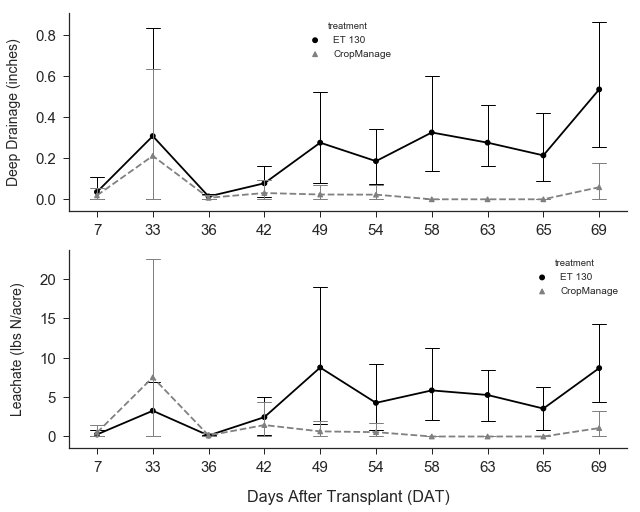

In [18]:
# plot scaled data using the tidy scaled data and the two variables created eary for each treatment name
explore_scaled_lysimeter_data(leachate_scaled, treatment_one=treatment_one, treatment_two=treatment_two)
plt.savefig('explore_scaled_lysimeter_data')

---

## Section 07: Plot and compare Total Applied Water vs. Total Deep Drainage. 

### First we gotta do some prep for the leachate data

In [19]:
# Filter out Grower treatment
applied_h2o_without_grower = applied_h2o.loc[applied_h2o['treatment'] != 'Grower']
applied_h2o_without_grower.head()

,date,DAP,treatment,irrigation_type,irrigation_in,irrigation_mm
0,2017-04-12,0,CropManage,sprinkler,1.20,30.480
1,2017-04-12,0,ET 130,sprinkler,1.20,30.480
3,2017-04-15,3,CropManage,sprinkler,0.33,8.382
4,2017-04-15,3,ET 130,sprinkler,0.33,8.382
6,2017-05-15,33,CropManage,drip,1.10,27.940


In [20]:
# create summary of total applied water and save each treatments totals in variables
total_applied_water = applied_h2o_without_grower.groupby('treatment').sum()
total_applied_water

,DAP,irrigation_in,irrigation_mm
treatment,,,
CropManage,506.0,7.90,200.660
ET 130,472.0,9.36,237.744
Grower,NaN,NaN,NaN


In [21]:
# save totals to variables for total applied water
cm_total_water = total_applied_water.loc[0,'irrigation_in']
print('crop manage: ', cm_total_water)
et130_total_water = total_applied_water.loc[1,'irrigation_in']
print('et130: ', et130_total_water)

crop manage:  7.9
et130:  9.36


### Now lets do some prep for the irrigation data 

In [22]:
# group lysimeter data by Treatment, then replicate and then sum to get total drainage per lysimeter
summed_leachate = leachate_scaled.groupby(['treatment','replicate']).sum()
summed_leachate = summed_leachate.reset_index()
summed_leachate.round(2)

,treatment,replicate,event,DAP,drainage_cm3,N_mg_per_L,drainage_in,drainage_L,N_mg,N_lbs,N_lbs_per_cm2,N_lbs_per_acre
0,CropManage,Rep A,55,476,403,80.40,0.23,0.40,32.40,0.0,0.0,4.28
1,CropManage,Rep B,55,476,2155,793.54,1.26,2.15,326.85,0.0,0.0,43.16
2,CropManage,Rep C,55,476,0,0.00,0.00,0.00,0.00,0.0,0.0,0.00
3,CropManage,Rep D,55,476,0,0.00,0.00,0.00,0.00,0.0,0.0,0.00
4,ET 130,Rep A,55,476,2038,398.19,1.19,2.04,141.77,0.0,0.0,18.72
5,ET 130,Rep B,55,476,6985,723.15,4.07,6.98,670.62,0.0,0.0,88.56
6,ET 130,Rep C,55,476,2545,1210.70,1.48,2.54,274.95,0.0,0.0,36.31
7,ET 130,Rep D,55,476,3832,497.50,2.23,3.83,199.78,0.0,0.0,26.38


In [23]:
# group lysimeter data by Treatment, then replicate and then sum
avg_drainage = summed_leachate.groupby(['treatment']).mean()

# view table summary and use to confirm results on figures below
avg_drainage = avg_drainage.reset_index()
avg_drainage

,treatment,event,DAP,drainage_cm3,N_mg_per_L,drainage_in,drainage_L,N_mg,N_lbs,N_lbs_per_cm2,N_lbs_per_acre
0,CropManage,55.0,476.0,639.5,218.485774,0.372664,0.6395,89.813738,0.000198,2.930778e-07,11.860438
1,ET 130,55.0,476.0,3850.0,707.382497,2.243560,3.8500,321.780213,0.000709,1.050025e-06,42.492990


In [24]:
# save average drainage to variables for adding text to plots
cm_avg_drainage = avg_drainage.loc[0,'drainage_in']
et130_avg_drainage = avg_drainage.loc[1,'drainage_in']
print('avg drainage for CM: ', cm_avg_drainage.round(2))
print('avg drainage for et130: ',et130_avg_drainage.round(2))

avg drainage for CM:  0.37
avg drainage for et130:  2.24


In [25]:
# calculate percent drainage 
cm_percent_drainage = cm_avg_drainage / cm_total_water * 100
print(cm_percent_drainage)

et130_percent_drainage = et130_avg_drainage / et130_total_water * 100
print(et130_percent_drainage)

4.71726565603
23.9696535969


## Create function for plotting 

In [26]:
def plot_applied_irrigation_vs_drainage(h2o_data, summed_leachate_data):
    fig, ax=plt.subplots(1,2,figsize=(13,7))
    
    # plot irrigation data for non-grower treatments (left plot)
    ax1 = sns.barplot(data=h2o_data, x='treatment', y='irrigation_in', order=order_2, 
                     estimator=sum, palette=colors_2, ci=None,  ax=ax[0])
    ax1.set_ylim(0,cm_total_water*3);  ax1.set_xlabel(xlabel=''); ax1.tick_params(labelsize=15); 
    ax1.set_ylabel('Total Applied Water (in)', fontsize=23, labelpad=12)
    ax1.set_title('Total Irrigation',fontweight='bold', fontsize=22)
    
    # add text for the total applied water in inches
    ax1.text(-.17, cm_total_water*1.05, str(cm_total_water.round(1)) + '"', fontsize=22) # Crop Manage
    ax1.text(.83, et130_total_water*1.05, str(et130_total_water.round(1)) + '"', fontsize=22) # 130 ET
    
    # increase size of x axis labels
    ax1.tick_params(axis='y', labelsize=18)
    ax1.tick_params(axis='x', labelsize=17)
    
    # plot drainage data (right plot)
    ax2 = sns.barplot(data=summed_leachate, x='treatment', y='drainage_in', 
                      ci=95, capsize=.1, order=order_2, palette=colors_2,  ax=ax[1])
    ax2.set_ylim(0,cm_total_water*3);  ax2.set_xlabel(xlabel='')
    ax2.set_ylabel('', fontsize=16, labelpad=12)
    
    # increase size of labels x and y labels
    ax2.tick_params(axis='y', labelsize=18)
    ax2.tick_params(axis='x', labelsize=17)
    
    # add text to plot to describe the comparisons between Total applied Irrigation and the Drainage
    ax2.text(-0.2, cm_avg_drainage+6, str(cm_avg_drainage.round(1)) + '" of' , fontsize=15, fontweight='bold') # Crop Manage
    ax2.text(-0.3, cm_avg_drainage+5, 'Drainage' , fontsize=15, fontweight='bold') # Crop Manage
    ax2.text(-0.4, cm_avg_drainage+3, '~ ' + str(cm_percent_drainage.round(1)) + '% of total' , 
             fontsize=15) # Crop Manage
    ax2.text(-0.4, cm_avg_drainage+2, 'applied water' , fontsize=15) # Crop Manage
    
    ax2.text(.8, et130_avg_drainage+6, str(et130_avg_drainage.round(1)) + '" of' , fontsize=15, fontweight='bold') # Crop Manage
    ax2.text(0.7, et130_avg_drainage+5, 'Drainage' , fontsize=15, fontweight='bold') # Crop Manage
    ax2.text(0.6, et130_avg_drainage+3, '~ ' + str(et130_percent_drainage.round(1)) + '% of total' , 
             fontsize=15) # Crop Manage
    ax2.text(0.6, et130_avg_drainage+2, 'applied water' , fontsize=15) # Crop Manage
    
    ax2.set_ylabel('Total Deep Drainage (in)', fontsize=22, labelpad=12)
    ax2.set_title('Deep Drainage',fontweight='bold', fontsize=22)
    
    wspace = .4  # the amount of width reserved for blank space between subplots,
               # expressed as a fraction of the average axis width
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                    wspace=wspace, hspace=None)

    sns.despine() # remove spines    
    
    return fig, ax

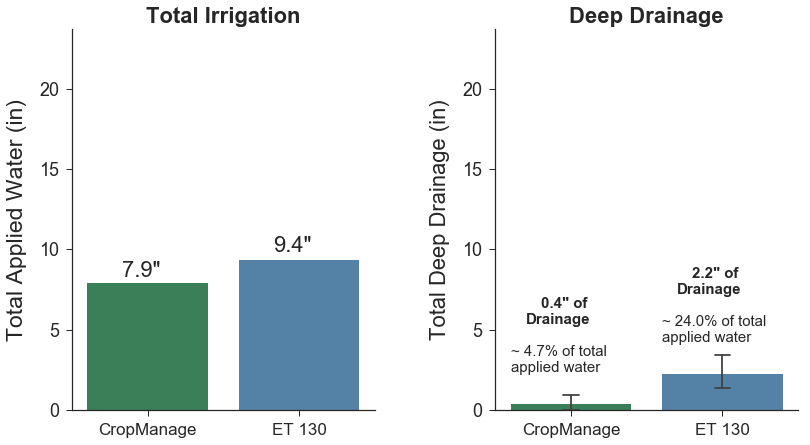

In [27]:
# use function to plot Total Irrigation vs. Deep Drainage
plot_applied_irrigation_vs_drainage(applied_h2o_without_grower, leachate_scaled)
plt.savefig('applied_irrigation_vs_drainage')

---

# Section 08: Plot and compare Total Applied Fertilizer vs. Total Leachate

### First lets do look at some summaries of our data and save them into variables to use when plotting

In [28]:
applied_N

,date,treatment,application_type,fertilizer,N_lbs_per_acre
0,2017-04-07,Grower,Bed Listing,2.5-12-30,10.0
1,2017-05-09,Grower,1st Sidedress,20-0-0,73.5
2,2017-05-24,Grower,1st Drip Fertigation,20-0-0,60.0
3,2017-06-08,Grower,2nd Drip Fertigation,CAN-17,42.8
4,2017-04-07,CropManage,Bed Listing,2.5-12-30,10.0
5,2017-05-09,CropManage,1st Sidedress,20-0-0,73.5
6,2017-05-24,CropManage,1st Drip Fertigation,20-0-0,39.9
7,2017-05-31,CropManage,2nd Drip Fertigation,20-0-0,30.0
8,2017-04-07,ET 130,Bed Listing,2.5-12-30,10.0
9,2017-05-09,ET 130,1st Sidedress,20-0-0,73.5


In [29]:
# sum applied fertlizer to see total applied N for each treatment
applied_N_summed = fertilizer.groupby('treatment').sum()

# save total applied N for each treatment in variables 
cm_applied_N = applied_N_summed.loc['CropManage','N_lbs_per_acre']
print('cm total applied N: ', cm_applied_N)

et130_applied_N = applied_N_summed.loc['ET 130','N_lbs_per_acre']
print('et130 total applied N: ', et130_applied_N)

cm total applied N:  153.4
et130 total applied N:  188.7


In [30]:
# groupby treatment and take the mean leachate
avg_leached_N = summed_leachate.groupby(['treatment']).mean()

# view dataframe with summaries for each treatment
avg_leached_N

,event,DAP,drainage_cm3,N_mg_per_L,drainage_in,drainage_L,N_mg,N_lbs,N_lbs_per_cm2,N_lbs_per_acre
treatment,,,,,,,,,,
CropManage,55.0,476.0,639.5,218.485774,0.372664,0.6395,89.813738,0.000198,2.930778e-07,11.860438
ET 130,55.0,476.0,3850.0,707.382497,2.243560,3.8500,321.780213,0.000709,1.050025e-06,42.492990


In [31]:
# average leached taking from summary table above
cm_avg_leached = avg_leached_N.loc['CropManage','N_lbs_per_acre']
et130_avg_leached = avg_leached_N.loc['ET 130','N_lbs_per_acre']
print('avg leached N for CM: ', cm_avg_leached)
print('avg leached N for et130: ',et130_avg_leached)

avg leached N for CM:  11.8604380123
avg leached N for et130:  42.4929901613


In [32]:
# calculate percent leached from total applied
cm_percent_leached = ( cm_avg_leached / cm_applied_N ) * 100
print('CM: ', cm_percent_leached.round(2), '% leached')

et130_percent_leached = ( et130_avg_leached / et130_applied_N ) * 100
print('et130: ', et130_percent_leached.round(2), '% leached')

CM:  7.73 % leached
et130:  22.52 % leached


In [33]:
def plot_applied_N_vs_leached_N(fertilizer_data, summed_leachate_data):
    fig, ax=plt.subplots(1,2,figsize=(13,7))
    
    # plot total applied N for each treatment
    ax1 = sns.barplot(data=fertilizer_data, x='treatment', y='N_lbs_per_acre', order=order_2, 
                      estimator=sum, palette=colors_2, ci=None,  ax=ax[0])
    
    ax1.set_ylim(0,300);  ax1.set_xlabel(xlabel='');
    ax1.set_ylabel('Total Applied N (lbs/acre)', fontsize=20, labelpad=12)
    ax1.set_title('Total Applied N',fontweight='bold', fontsize=22)
    
    # add text for the total applied water in inches (CHANGE THIS TEXT)
    ax1.text(-.17, cm_applied_N*1.05, str(cm_applied_N.round(1)), fontsize=22) # Crop Manage
    ax1.text(.83, et130_applied_N*1.05, str(et130_applied_N.round(1)), fontsize=22) # 130 ET
    
    ax1.tick_params(axis='y', labelsize=18)
    ax1.tick_params(axis='x', labelsize=17)
    
    # plot leached nitrogen data (right side)
    ax2 = sns.barplot(data=summed_leachate_data, x='treatment', y='N_lbs_per_acre', order=order_2, 
                      palette=colors_2, ci=95, capsize=.1)
    ax2.set_ylim(0,300);  ax2.set_xlabel(xlabel='');
    ax2.set_ylabel('Leached N (lbs/acre)', fontsize=20, labelpad=12)
    ax2.set_title('Leached Nitrogen',fontweight='bold', fontsize=22)
    ax2.tick_params(axis='y', labelsize=18)
    ax2.tick_params(axis='x', labelsize=17)
    
    # add text for the comparing total applied to total leached
    ax2.text(-0.28, cm_avg_leached+85, str(cm_avg_leached.round(1)) + ' lbs. of' , fontsize=15, fontweight='bold') # Crop Manage
    ax2.text(-0.3, cm_avg_leached+70, 'N leached' , fontsize=15, fontweight='bold') # Crop Manage
    ax2.text(-0.4, cm_avg_leached+45, str(cm_percent_leached.round(1)) + '% of total' , 
             fontsize=15) # Crop Manage
    ax2.text(-0.4, cm_avg_leached+30, 'applied N' , fontsize=15) # Crop Manage

    ax2.text(0.7, et130_avg_leached+95, str(et130_avg_leached.round(1)) + ' lbs. of' , fontsize=15, fontweight='bold') # Crop Manage
    ax2.text(0.7, et130_avg_leached+80, 'N leached' , fontsize=15, fontweight='bold') # Crop Manage
    ax2.text(0.6, et130_avg_leached+55, str(et130_percent_leached.round(1)) + '% of total' , 
             fontsize=15) # Crop Manage
    ax2.text(0.6, et130_avg_leached+40, 'applied N' , fontsize=15) # Crop Manage


    wspace = .4  # the amount of width reserved for blank space between subplots,
               # expressed as a fraction of the average axis width
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                    wspace=wspace, hspace=None)

    sns.despine() # remove spines    
    
    return fig, ax

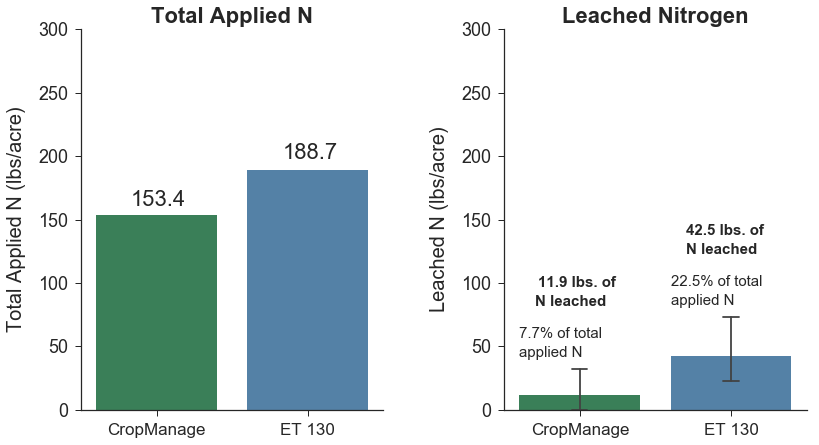

In [34]:
# use function to plot Total Applied N vs. Average Leached N
plot_applied_N_vs_leached_N(applied_N, summed_leachate)
plt.savefig('applied_N_vs_leached_N')